# Figure 16: colour plot of the individual state entropies for the 30 mosquito model with reversion.

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

Import required libraries

In [1]:
import numpy as np
import pylab as plt
import matplotlib
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

Import required scripts

In [2]:
import importlib
import Rate_transitions
import Finding_dictionary_keys
import Hughes_model
import Entropies
import Finding_full_Q
import Tridiagonalisation
import Finding_sub_Q
import Lower_block_triangular

get_transition = Rate_transitions.get_transition_Hughes
find_keys = Finding_dictionary_keys.find_keys
F = Hughes_model.F_hughes
entropy = Entropies.entropy
getQ = Finding_full_Q.getQ_Hughes
tridiagonal = Tridiagonalisation.tridiagonal
getQk = Finding_sub_Q.getQk_Hughes
LBTQ = Lower_block_triangular.LBTQ_Hughes

# scripts autosave, so no need to re-run code chunk after making changes
%load_ext autoreload
%autoreload 2

Parameter values

In [3]:
K = 30        # reproductive carrying capacity
d1 = 12/100   # wild-type death rate
d2 = 12/100   # Wolbachia death rate
phi = 9/10    # Wolbachia fitness

v = 9/10      # probability of vertical transmission
u = 10/10     # ratio of unviable offspring produced by an infected male and uninfected female

k = 0.3           # Mosquito competition parameter
h = 0.19*100**k   # Mosquito competition parameter

b1 = round(d1/F(10,h,k),2) # wild-type per capita birth rate
b2 = b1*phi                # Wolbachia per capita birth rate

# create a dictionary to store all parameter values
params_dict = {'b1': b1,
              'b2': b2,
              'K': K,
              'd1': d1,
              'd2': d2,
              'v': v,
              'phi': phi,
              'u': u,
              'h': h,
              'k': k
              }

Construct dictionaries for the full state space

In [4]:
# construct a dictionary that associated an integer index with each possible states, states are stored as an np.array - easier to apply mathematical operations than tuple 
max_pop = 30 # maximum household size
state_dict = {index: np.array((i, j)) for index, (i, j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(max_pop + 1) if i + j <= max_pop])}

Finding the full Q matrix

In [5]:
# construct a matrix Q for the transition rate q_ij betweeen states i and j
n_states = len(state_dict)  # total number of states
Q = getQ(state_dict,params_dict)

Constructing dictionaries for each communicating class and their sub-Q matrices

In [6]:
### S1 corresponds to the wild-type-only states, S2 to the Wolbachia-only and mixed states
state_dict_S1 = {index: np.array((i, 0)) for index, i in enumerate([i for i in range(1,max_pop + 1)])}
state_dict_S2 = {index: np.array((i,j)) for index, (i,j) in enumerate([(i, j) for i in range(max_pop + 1) for j in range(1,max_pop + 1) if i + j <= max_pop])}

# finding the sub-q matrices and their respective ordered lists of states in the class
# we will use these list to rearrange Q into lower block triangular form
Q1,key_list1 = getQk(state_dict_S1,state_dict,Q,params_dict)
Q2,key_list2 = getQk(state_dict_S2,state_dict,Q,params_dict)

Finding the lower block triangular form of Q

In [7]:
Q_lower_block_triang, state_dict_relabel = LBTQ(Q,state_dict,state_dict_S1,state_dict_S2,max_pop,params_dict)

Finding the QSD

In [8]:
# we take the transpose of Q so we obtain the left eigenvector not right
evals, evecs = np.linalg.eig(Q_lower_block_triang.T)  # all eigenvalues and eigenvectors
decay_indx = np.argmax([x for x in evals if x != 0])  # index for over all eigenvalue of minimal magnitude
uvec = evecs[:,decay_indx]                # the corresponding left eigenvector
quasi_stat_dist = uvec/np.sum(uvec)       # normalising to sum to 1

Calculating the total and individual state entropies

In [9]:
H_vec, H = entropy(Q_lower_block_triang,quasi_stat_dist)

Putting the entopies into an array in the correct format for the colour plot

In [10]:
col_map_entr = np.zeros((max_pop+1,max_pop+1))  # intialising the array for the colour plot
    
for k in range(n_states-1):               # looping over the state space
    # setting the index of the current entropy value corresponding to the intial state
    indx1, indx2 = state_dict_relabel[k]  
    col_map_entr[indx1,indx2] = H_vec[k]   # recording the entropy value

Plotting the Figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


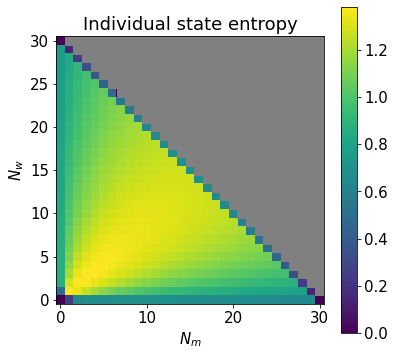

In [11]:
plt.figure(figsize=(6, 6))                       # figure size
matplotlib.rcParams.update({'font.size': 15})    # font size

Z = np.transpose(col_map_entr)      # putting the array the correct way round for the colour plot
my_cmap = plt.cm.viridis            # colour scheme
num_levels = 100000
my_cmap = ListedColormap(my_cmap(np.linspace(0, 1, num_levels)))     # define how fine a colour scale want
plt.imshow(Z, cmap = my_cmap, interpolation='nearest', origin='lower')  # produces colour plot
plt.xlabel('$N_m$')   # x label
plt.ylabel('$N_w$')   # y label

current_axes = plt.gca()    # saves current axes
# colours the squares corresponding to the state space that is out of bounds grey
for i in range(max_pop):   # looping over the y axis
    highlight_row, highlight_col = max_pop-i,1+i
    rect = Rectangle((highlight_col - 0.5, highlight_row - 0.5), max_pop, 1, edgecolor='gray', facecolor='gray')
    current_axes.add_patch(rect)  # adds the rectangle

plt.colorbar()    # adds colour bar
plt.title('Individual state entropy'.format(phi))     # title
plt.savefig('entropy_v09.pdf', bbox_inches='tight')   # save figure